In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "cs231n/assignments/assignment1/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/MyDrive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/MyDrive/$FOLDERNAME

ModuleNotFoundError: ignored

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.350735
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ it's the loss of random chioce for 10 classes




In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.013307 analytic: 1.013307, relative error: 4.306436e-08
numerical: 1.280347 analytic: 1.280347, relative error: 5.157657e-08
numerical: 1.511866 analytic: 1.511866, relative error: 1.836199e-08
numerical: 0.165116 analytic: 0.165116, relative error: 1.665327e-07
numerical: -3.805397 analytic: -3.805397, relative error: 9.672780e-09
numerical: -2.035857 analytic: -2.035857, relative error: 7.730910e-09
numerical: -4.987064 analytic: -4.987064, relative error: 5.487910e-09
numerical: 0.803496 analytic: 0.803495, relative error: 3.946991e-08
numerical: 0.453574 analytic: 0.453574, relative error: 7.414053e-08
numerical: -0.075289 analytic: -0.075289, relative error: 4.056989e-07
numerical: -1.667692 analytic: -0.481227, relative error: 5.521215e-01
numerical: -2.894039 analytic: -1.715147, relative error: 2.557701e-01
numerical: -1.351597 analytic: -0.177767, relative error: 7.675277e-01
numerical: 1.349483 analytic: 2.507120, relative error: 3.001700e-01


KeyboardInterrupt: ignored

In [ ]:
a= np.array([[1,2,3],[1,2,3]])
np.sum(a, axis=1)

array([6, 6])

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.353833e+00 computed in 6.593828s
vectorized loss: 2.353833e+00 computed in 0.016477s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
from cs231n.classifiers.softmax import softmax_loss_vectorized
class Softmax:
  def __init__(self, lr, reg):
    self.W = np.random.randn(3073, 10) * 0.0001
    self.lr = lr
    self.reg = reg
    self.no_of_batches = 10
    print("LR:",lr)
    print("Reg:",reg)
  def train(self, X, y, iter):
    t = time.time()
    batch_size = int(X.shape[0]/self.no_of_batches)
    for i in range(iter):
      batch_no = iter%self.no_of_batches
      xs = X[batch_no*batch_size:(batch_no+1)*batch_size,:]
      ys = y[batch_no*batch_size:(batch_no+1)*batch_size]
      loss, grad = softmax_loss_vectorized(self.W, xs, ys, self.reg)
      self.W -=grad*self.lr
    print("Iter:{}, Loss:{}, Time:{}".format(iter, loss, time.time()-t))
  def predict(self, X):
    scores = np.exp(X.dot(self.W))
    scores_normalized = scores/scores.sum(axis=1).reshape(X.shape[0], 1)
    return np.argmax(scores_normalized, axis=1)
  def test(self, X, y):
    results = self.predict(X)
    return np.sum(results==y)/y.shape[0]


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.


results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e-4, 5e-4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

s = 10
iter = 500
lr_s = (learning_rates[1]-learning_rates[0])/s
reg_s = (regularization_strengths[0]-regularization_strengths[1])/s

for i in range(s):
  lr = learning_rates[0] + i*lr_s
  reg = regularization_strengths[0] - i*reg_s
  sm = Softmax(lr, reg)
  sm.train(X_train, y_train, iter)
  results[(lr, reg)] = (sm.test(X_train, y_train), sm.test(X_val, y_val))
  print((lr, reg), "=>", results[(lr, reg)])
  if results[(lr, reg)][1] > best_val:
    best_val = results[(lr, reg)][1]
    best_softmax = sm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

LR: 1e-07
Reg: 0.00025
Iter:500, Loss:1.8455915874591227, Time:55.99907994270325
(1e-07, 0.00025) => (0.3406326530612245, 0.367)
LR: 1.3999999999999998e-07
Reg: 0.000275
Iter:500, Loss:1.8020883422168632, Time:56.70958423614502
(1.3999999999999998e-07, 0.000275) => (0.35459183673469385, 0.353)
LR: 1.8e-07
Reg: 0.00030000000000000003
Iter:500, Loss:1.778655074977252, Time:54.95512866973877
(1.8e-07, 0.00030000000000000003) => (0.3596530612244898, 0.375)
LR: 2.2e-07
Reg: 0.000325
Iter:500, Loss:1.754939145836859, Time:58.14509034156799
(2.2e-07, 0.000325) => (0.3629591836734694, 0.379)
LR: 2.6e-07
Reg: 0.00035
Iter:500, Loss:1.7372740860893694, Time:55.45697331428528
(2.6e-07, 0.00035) => (0.36726530612244895, 0.363)
LR: 3e-07
Reg: 0.000375
Iter:500, Loss:1.7225813413759588, Time:55.98101544380188
(3e-07, 0.000375) => (0.36995918367346936, 0.394)
LR: 3.4000000000000003e-07
Reg: 0.0004
Iter:500, Loss:1.7064010726400198, Time:55.25296592712402
(3.4000000000000003e-07, 0.0004) => (0.3748367

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.379000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ yes


$\color{blue}{\textit Your Explanation:}$ if the added datapoint is correctly classified by the SVM and scores for other classes is below the threshold, it would not add any loss to the ovaral loss, yet if you are adding a similar point to the Softmax, it always contribute to the total loss.



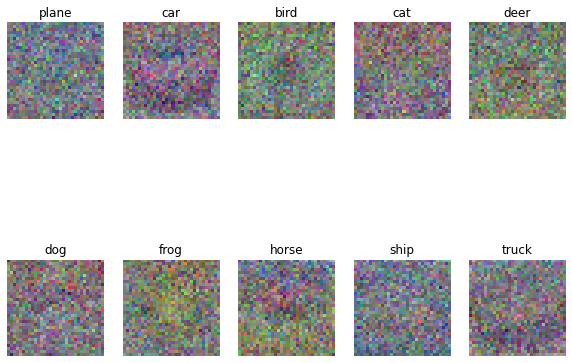

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

